In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import pygad



In [ ]:
# SEED for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Reading dataset
df = pd.read_csv('../data_per_month.csv')
df = df['Total Renewable Energy']

# Scaling the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

In [ ]:
# Define sequence length
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [ ]:
# Preparing the data
time_steps = 12
X, y = create_sequences(data_scaled, time_steps)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# # Convertendo os dados para float32 (evita retracing por tipos diferentes)
# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)
# X_test = X_test.astype(np.float32)

#Constructing the model LSTM
def build_model(neurons_1, neurons_2, dense_units, learning_rate):
    model = Sequential([
        Input(shape=(time_steps, 1)),
        LSTM(neurons_1, activation='relu', return_sequences=True),
        LSTM(neurons_2, activation='relu'),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [ ]:
# Fitness function for the genetic algorithm
def fitness_func(ga_instance, solution, sol_idx):
    try:
        neurons_1 = int(solution[0])
        neurons_2 = int(solution[1])
        dense_units = int(solution[2])
        learning_rate = float(solution[3])
        batch_size = int(solution[4])
        epochs = int(solution[5])

        neurons_1 = max(8, min(neurons_1, 128))
        neurons_2 = max(8, min(neurons_2, 128))
        dense_units = max(8, min(dense_units, 128))
        learning_rate = max(1e-5, min(learning_rate, 1e-1))
        batch_size = max(8, min(batch_size, 128))
        epochs = max(5, min(epochs, 200))

        print(f"[FITNESS] LSTM1={neurons_1}, LSTM2={neurons_2}, Dense={dense_units}, LR={learning_rate:.5f}, Batch={batch_size}, Epochs={epochs}")

        model = build_model(neurons_1, neurons_2, dense_units, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        preds = model.predict(X_test, verbose=0)
        mse = mean_squared_error(y_test, preds)
        return 1.0 / (mse + 1e-8)

    except Exception as e:
        print(f"[ERRO NA FITNESS] {e}")
        return 0




# Defining the gene space for the genetic algorithm
gene_space = [
    {'low': 16, 'high': 128},     # neurons LSTM layer 1
    {'low': 16, 'high': 128},     # neurons LSTM layer 2
    {'low': 8, 'high': 64},       # neurons layer dense
    {'low': 1e-4, 'high': 1e-2},  # learning rate
    {'low': 16, 'high': 128},     # batch size
    {'low': 5, 'high': 30}        # epochs
]

# Defining the genetic algorithm instance
ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=len(gene_space),
    gene_space=gene_space,
    parent_selection_type="rank",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    on_generation=lambda ga: print(f"Ger {ga.generations_completed} - Best fitness: {ga.best_solution()[1]:.6f}")
)

# Running the genetic algorithm
ga_instance.run()

[FITNESS] LSTM1=57, LSTM2=122, Dense=48, LR=0.00603, Batch=33, Epochs=8


2025-06-04 11:14:48.738422: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-06-04 11:14:48.738443: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: NuTec
2025-06-04 11:14:48.738446: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: NuTec
2025-06-04 11:14:48.738548: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 570.153.2
2025-06-04 11:14:48.738560: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 570.153.2
2025-06-04 11:14:48.738562: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 570.153.2


[FITNESS] LSTM1=22, LSTM2=113, Dense=41, LR=0.00711, Batch=18, Epochs=29
[FITNESS] LSTM1=109, LSTM2=39, Dense=18, LR=0.00192, Batch=50, Epochs=18
[FITNESS] LSTM1=64, LSTM2=48, Dense=42, LR=0.00148, Batch=48, Epochs=14
[FITNESS] LSTM1=67, LSTM2=103, Dense=19, LR=0.00519, Batch=82, Epochs=6
[FITNESS] LSTM1=84, LSTM2=35, Dense=11, LR=0.00949, Batch=124, Epochs=25
[FITNESS] LSTM1=50, LSTM2=26, Dense=46, LR=0.00446, Batch=29, Epochs=17
[FITNESS] LSTM1=19, LSTM2=117, Dense=22, LR=0.00666, Batch=50, Epochs=18
[FITNESS] LSTM1=77, LSTM2=36, Dense=62, LR=0.00777, Batch=121, Epochs=27
[FITNESS] LSTM1=82, LSTM2=119, Dense=12, LR=0.00204, Batch=21, Epochs=13
[FITNESS] LSTM1=108, LSTM2=39, Dense=18, LR=0.00603, Batch=33, Epochs=8
[FITNESS] LSTM1=57, LSTM2=122, Dense=48, LR=0.00603, Batch=82, Epochs=5
[FITNESS] LSTM1=22, LSTM2=113, Dense=41, LR=0.00711, Batch=18, Epochs=29
[FITNESS] LSTM1=22, LSTM2=113, Dense=42, LR=0.00711, Batch=18, Epochs=29
[FITNESS] LSTM1=22, LSTM2=113, Dense=41, LR=0.00711, Bat

In [33]:
# Catching the best solution
solution, fitness, _ = ga_instance.best_solution()
print("\nMelhor conjunto de hiperparâmetros encontrados:")
print(f"LSTM1: {int(solution[0])}, LSTM2: {int(solution[1])}")
print(f"Dense: {int(solution[2])}, Learning rate: {solution[3]:.5f}")
print(f"Batch size: {int(solution[4])}, Épocas: {int(solution[5])}")

[FITNESS] LSTM1=21, LSTM2=113, Dense=41, LR=0.00010, Batch=33, Epochs=9
[FITNESS] LSTM1=20, LSTM2=112, Dense=41, LR=0.00010, Batch=33, Epochs=9
[FITNESS] LSTM1=20, LSTM2=113, Dense=41, LR=0.00010, Batch=18, Epochs=9
[FITNESS] LSTM1=21, LSTM2=113, Dense=41, LR=0.00010, Batch=33, Epochs=9
[FITNESS] LSTM1=20, LSTM2=113, Dense=41, LR=0.00010, Batch=33, Epochs=9

Melhor conjunto de hiperparâmetros encontrados:
LSTM1: 22, LSTM2: 112
Dense: 41, Learning rate: 0.00711
Batch size: 18, Épocas: 29


In [ ]:
### Implementing the best solution of the genetic algorithm in the LSTM model

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    Input(shape=((time_steps, 1))),
    LSTM(22, activation='relu', return_sequences=True),
    LSTM(113, activation='relu'),
    Dense(41, activation='relu'),
    Dense(1)
])
optimizer= Adam(learning_rate=0.00711)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=29, batch_size=18, validation_data=(X_test, y_test), verbose=1)


test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


y_pred = model.predict(X_test)


y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)



Epoch 1/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0312 - mae: 0.1316 - val_loss: 0.0159 - val_mae: 0.1050
Epoch 2/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0429 - val_loss: 0.0047 - val_mae: 0.0559
Epoch 3/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mae: 0.0412 - val_loss: 0.0050 - val_mae: 0.0568
Epoch 4/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0407 - val_loss: 0.0048 - val_mae: 0.0555
Epoch 5/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mae: 0.0406 - val_loss: 0.0048 - val_mae: 0.0554
Epoch 6/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mae: 0.0404 - val_loss: 0.0047 - val_mae: 0.0549
Epoch 7/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mae: 0.0401 - val_loss: 0.0046 - val_mae: 0.0547
Epoch 8/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mae: 0.0400 - val_loss: 0.0046 - val_mae: 0.0554
Epoch 9/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mae:

MAE: 25.1144
MSE: 945.4543
RMSE: 30.7482
R² Score: 0.2878


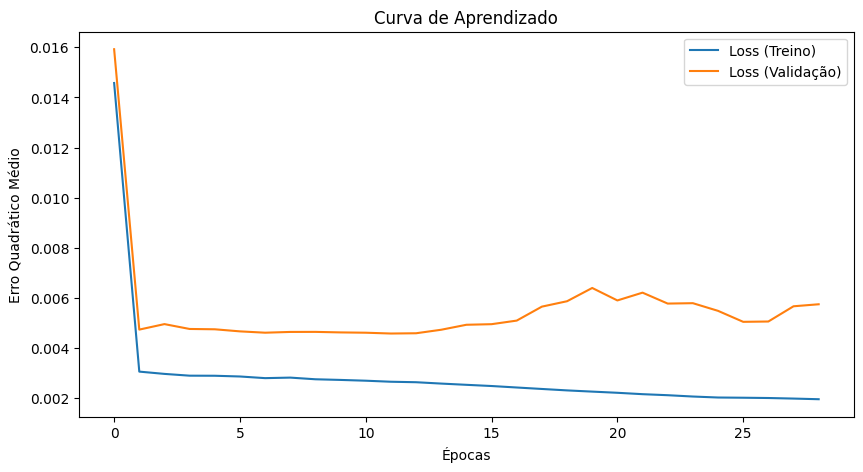

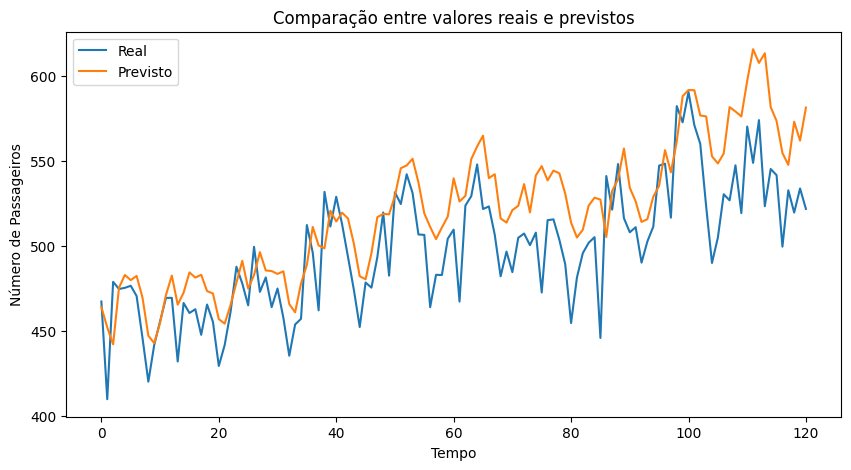

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss (Treino)')
plt.plot(history.history['val_loss'], label='Loss (Validação)')
plt.xlabel('Épocas')
plt.ylabel('Erro Quadrático Médio')
plt.legend()
plt.title('Curva de Aprendizado')
plt.show()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto')
plt.xlabel('Tempo')
plt.ylabel('Número de Passageiros')
plt.legend()
plt.title('Comparação entre valores reais e previstos')
plt.show()